In [188]:
import os, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv


In [189]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)
rng = np.random.default_rng(7)

# Config 

In [190]:
@dataclass
class SimCfg:
    N:int=80; K:int=6; Fs:int=10
    L:float=500.0
    noise:float=1e-13
    Pmin:float=50e-3; Pmax:float=200e-3
    SL:float=1.2; SW:float=1.0; c_price:float=1.0

In [191]:
def pathloss_gain(d, pl_ref_gain_db=-30.0, n=3.2, d0=1.0):
    d = np.maximum(d, 1.0)
    PL_dB = pl_ref_gain_db + 10.0*n*np.log10(d/d0)
    return 10.0**(-PL_dB/10.0)

In [192]:
class StandardScalerNP:
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = X.mean(0)
        self.std_ = X.std(0)
        self.std_[self.std_==0]=1.0
    def transform(self, X): return (X-self.mean_)/self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

# Generate dataset 

In [193]:
def generate_dataset(cfg: SimCfg, seed=7):
    rng = np.random.default_rng(seed)
    N, K, Fs = cfg.N, cfg.K, cfg.Fs

    users = rng.uniform(0, cfg.L, (N,2))
    aps   = rng.uniform(0, cfg.L, (K,2))
    bs    = np.array([cfg.L/2, cfg.L/2])

    # Channels
    d_iL = np.linalg.norm(users - bs, axis=1)
    g_iL = pathloss_gain(d_iL) * rng.exponential(1.0, N)              # (N,)
    d_ik = np.linalg.norm(users[:,None,:] - aps[None,:,:], axis=2)
    g_ik = pathloss_gain(d_ik) * rng.exponential(1.0, (N,K))          # (N,K)

    # User params
    Ci   = np.full(N, 8.0, dtype=np.float32)  #rng.uniform(0.0, 8.0, N)
    Lthr = np.full(N, 1.0, dtype=np.float32) #rng.uniform(0.3, 0.8, N)
    Pmax = np.full(N, 1.0, dtype=np.float32) #rng.uniform(cfg.Pmin, cfg.Pmax, N)

    # Build a fixed interference graph
    # Use edges weighted by "potential interference strength" ~ gbar_ij_base:
    # choose base w_iL = 0.5, w_ik = uniform over K to get a prior
    wL_base = 0.5*np.ones(N)
    wW_base = (0.5/K) * np.ones((N,K))
    # Hbar_base[i,j] = wL_i*g_jL + sum_k wW_i,k * g_jk = (wL)[:,None]*g_L[None,:] + wW @ g_ik^T
    Hbar_base = (wL_base[:,None] * g_iL[None,:]) + wW_base @ g_ik.T
    np.fill_diagonal(Hbar_base, 0.0)

    # Build edges: connect top-T strongest potential interferers per node
    T = min(12, N-1)
    edge_src, edge_dst, edge_w = [], [], []
    for i in range(N):
        js = np.argsort(-Hbar_base[i])[:T]
        for j in js:
            edge_src.append(i); edge_dst.append(j); edge_w.append(Hbar_base[i,j])
    edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
    edge_weight = torch.tensor(edge_w, dtype=torch.float32)

    # Features: basic numeric fields
    df = pd.DataFrame({
        "Pmax": Pmax, "Ci": Ci, "Lthr": Lthr, "g_iL": g_iL,
    })
    for k in range(K): df[f"g_i{k}"] = g_ik[:,k]
    X = df.to_numpy(np.float32)
    scaler = StandardScalerNP(); X = scaler.fit_transform(X)

    data = Data(
        x=torch.tensor(X, dtype=torch.float32, device=device),
        edge_index=edge_index.to(device),
        edge_weight=edge_weight.to(device)
    )
    aux = {
        "g_iL": torch.tensor(g_iL, dtype=torch.float32, device=device),   # (N,)
        "g_ik": torch.tensor(g_ik, dtype=torch.float32, device=device),   # (N,K)
        "Pmax": torch.tensor(Pmax, dtype=torch.float32, device=device),   # (N,)
        "Ci":   torch.tensor(Ci,   dtype=torch.float32, device=device),   # (N,)
        "Lthr": torch.tensor(Lthr, dtype=torch.float32, device=device),   # (N,)
        "noise": torch.tensor(cfg.noise, dtype=torch.float32, device=device),
        "SL": torch.tensor(cfg.SL, dtype=torch.float32, device=device),
        "SW": torch.tensor(cfg.SW, dtype=torch.float32, device=device),
        "cprice": torch.tensor(cfg.c_price, dtype=torch.float32, device=device),
        "N": N, "K": K, "F": Fs
    }
    return data, aux

In [194]:
cfg = SimCfg()
data, aux = generate_dataset(cfg, seed=7)

# Policy-GCN

In [195]:
class PolicyGCN(nn.Module):
    def __init__(self, in_dim, hidden, K, Fs):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        # outputs:
        self.recv_head = nn.Linear(hidden, K+1)  # [LTE | AP1..APK]
        self.band_head = nn.Linear(hidden, Fs)    # subband logits
        self.pow_head  = nn.Linear(hidden, 1)    # power logit -> sigmoid

    def forward(self, x, edge_index, edge_weight=None):
        h = self.conv1(x, edge_index, edge_weight=edge_weight)
        h = F.relu(h)
        h = self.conv2(h, edge_index, edge_weight=edge_weight)
        h = F.relu(h)
        recv_logits = self.recv_head(h)          # (N, K+1)
        band_logits = self.band_head(h)          # (N, F)
        pow_logit   = self.pow_head(h).squeeze(-1)  # (N,)
        w_rx = F.softmax(recv_logits, dim=-1)    # (N, K+1)
        p_f  = F.softmax(band_logits, dim=-1)    # (N, F)
        a    = torch.sigmoid(pow_logit)          # (N,)
        return w_rx, p_f, a, (recv_logits, band_logits, pow_logit)

In [196]:
policy = PolicyGCN(in_dim=data.x.size(-1), hidden=256, K=cfg.K, Fs=cfg.Fs).to(device)
opt = torch.optim.AdamW(policy.parameters(), lr=2e-3, weight_decay=1e-3)

# Differentiable objective: maximize total satisfaction

In [197]:
def objective_total_satisfaction(w_rx, p_f, a, aux):
    """
    w_rx: (N, K+1)  -> wL = [:,0], wW = [:,1:]
    p_f:  (N, F)    -> per-user subband soft assignment
    a:    (N,)      -> power fraction in [0,1]
    Returns: (mean_L, penalties_dict)
    """
    g_iL = aux["g_iL"]    # (N,)
    g_ik = aux["g_ik"]    # (N,K)
    Pmax = aux["Pmax"]    # (N,)
    Ci   = aux["Ci"]      # (N,)
    Lthr = aux["Lthr"]    # (N,)
    noise = aux["noise"]  # scalar
    SL, SW = aux["SL"], aux["SW"]
    cprice = aux["cprice"]
    N, K, Fs = aux["N"], g_ik.size(1), p_f.size(1)

    wL = w_rx[:, 0]         # (N,)
    wW = w_rx[:, 1:]        # (N,K)

    # desired gain for user i: h_des[i]
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                # (N,)

    # interference matrix Hbar_soft: H[i,j] = wL[i]*g_L[j] + sum_k wW[i,k]*g_ik[j,k]
    term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)               # (N,N)
    term2 = wW @ g_ik.transpose(0,1)                          # (N,N)
    Hbar = term1 + term2
    Hbar.fill_diagonal_(0.0)

    # transmit power
    P = a * Pmax                                              # (N,)

    # SINR_i = sum_f p_if * (P_i*h_des[i]) / (sum_j p_jf * P_j * Hbar[i,j] + noise)
    num = P * h_des                                           # (N,)
    SINR = torch.zeros_like(num)
    for f in range(Fs):
        S_f = p_f[:, f] * P                                   # (N,)
        denom = Hbar @ S_f + noise                            # (N,)
        SINR = SINR + p_f[:, f] * (num / (denom + 1e-30))
    rate = torch.log2(1.0 + SINR)                             # (N,)

    # Satisfaction
    S_i = SW + (SL - SW) * wL                                 # (N,)
    L_i = S_i * rate                                          # (N,)

    mean_L = L_i.mean()

    # Penalties:
    # Budget (LTE): c * r_i * wL <= Ci  -> relu(c*r_i*wL - Ci)
    budget_violation = F.relu(cprice * rate * wL - Ci).mean()

    # QoS: L_i >= Lthr  -> relu(Lthr - L_i)
    qos_violation = F.relu(Lthr - L_i).mean()

    penalties = {
        "budget": budget_violation,
        "qos": qos_violation
    }
    return mean_L, penalties

In [198]:
EPOCHS = 10000
lambda_budget = 10.0
lambda_qos    = 10.0

logs = []
for ep in range(1, EPOCHS+1):
    policy.train(); opt.zero_grad()
    w_rx, p_f, a, _ = policy(data.x, data.edge_index, data.edge_weight)
    mean_L, pens = objective_total_satisfaction(w_rx, p_f, a, aux)
    loss = -mean_L + lambda_budget * pens["budget"] + lambda_qos * pens["qos"]
    loss.backward()
    opt.step()

    if ep % 100 == 0 or ep == 1:
        with torch.no_grad():
            # report a few interpretable scalars
            avg_wL = w_rx[:,0].mean().item()
            avg_power = (a*aux["Pmax"]).mean().item()
            print(f"Ep {ep:03d} | Loss {loss.item():.6f} | meanL {mean_L.item():.4f} "
                  f"| budget {pens['budget'].item():.4f} | qos {pens['qos'].item():.4f} "
                  f"| <wLTE> {avg_wL:.3f} | <P> {avg_power*1e3:.2f} mW")
    logs.append({
        "epoch": ep,
        "loss": float(loss.item()),
        "meanL": float(mean_L.item()),
        "budget": float(pens["budget"].item()),
        "qos": float(pens["qos"].item())
    })


Ep 001 | Loss 9.280537 | meanL 0.1116 | budget 0.0000 | qos 0.9392 | <wLTE> 0.137 | <P> 518.39 mW


Ep 100 | Loss 4.725005 | meanL 0.5144 | budget 0.0000 | qos 0.5239 | <wLTE> 0.454 | <P> 329.91 mW
Ep 200 | Loss 4.070486 | meanL 0.5601 | budget 0.0000 | qos 0.4631 | <wLTE> 0.345 | <P> 478.20 mW
Ep 300 | Loss 3.790875 | meanL 0.5964 | budget 0.0000 | qos 0.4387 | <wLTE> 0.389 | <P> 555.32 mW
Ep 400 | Loss 3.671368 | meanL 0.6086 | budget 0.0000 | qos 0.4280 | <wLTE> 0.402 | <P> 534.89 mW
Ep 500 | Loss 3.583109 | meanL 0.6193 | budget 0.0000 | qos 0.4202 | <wLTE> 0.414 | <P> 502.50 mW
Ep 600 | Loss 3.465703 | meanL 0.6349 | budget 0.0000 | qos 0.4101 | <wLTE> 0.397 | <P> 459.34 mW
Ep 700 | Loss 3.379009 | meanL 0.6507 | budget 0.0000 | qos 0.4030 | <wLTE> 0.420 | <P> 417.62 mW
Ep 800 | Loss 3.329155 | meanL 0.6782 | budget 0.0000 | qos 0.4007 | <wLTE> 0.413 | <P> 409.99 mW
Ep 900 | Loss 3.177670 | meanL 0.7375 | budget 0.0000 | qos 0.3915 | <wLTE> 0.423 | <P> 273.49 mW
Ep 1000 | Loss 3.040623 | meanL 0.8087 | budget 0.0000 | qos 0.3849 | <wLTE> 0.404 | <P> 214.01 mW
Ep 1100 | Loss 2.97

# Test performance 

In [199]:
@torch.no_grad()
def evaluate_policy_snapshot(policy, data, aux):
    policy.eval()
    w_rx, p_f, a, _ = policy(data.x, data.edge_index, data.edge_weight)

    # Unpack
    g_iL = aux["g_iL"]      # (N,)
    g_ik = aux["g_ik"]      # (N,K)
    Pmax = aux["Pmax"]      # (N,)
    Ci   = aux["Ci"]        # (N,)
    Lthr = aux["Lthr"]      # (N,)
    noise = aux["noise"]    # scalar
    SL, SW = aux["SL"], aux["SW"]
    cprice = aux["cprice"]

    N = g_iL.size(0)
    wL = w_rx[:, 0]
    wW = w_rx[:, 1:]                         # (N,K)

    # Desired gain & interference matrix
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                  # (N,)
    term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)                 # (N,N)
    term2 = wW @ g_ik.transpose(0,1)                            # (N,N)
    Hbar  = term1 + term2
    Hbar.fill_diagonal_(0.0)

    # Power, SINR, rate
    P = a * Pmax                                                # (N,)
    num = P * h_des
    SINR = torch.zeros_like(num)
    Fbands = p_f.size(1)
    for f in range(Fbands):
        S_f = p_f[:, f] * P                                     # (N,)
        denom = Hbar @ S_f + noise
        SINR += p_f[:, f] * (num / (denom + 1e-30))
    rate = torch.log2(1.0 + SINR)

    # Satisfaction & constraints
    S_i = SW + (SL - SW) * wL
    L_i = S_i * rate
    budget_violation = torch.relu(cprice * rate * wL - Ci)      # per-user
    qos_violation    = torch.relu(Lthr - L_i)                   # per-user

    # Aggregate stats
    stats = {
        "mean_L": float(L_i.mean().item()),
        "mean_rate": float(rate.mean().item()),
        "mean_wLTE": float(wL.mean().item()),
        "mean_P": float((P).mean().item()),
        "budget_violation_mean": float(budget_violation.mean().item()),
        "qos_violation_mean": float(qos_violation.mean().item()),
    }
    per_user = {
        "wL": wL.detach().cpu().numpy(),
        "P": P.detach().cpu().numpy(),
        "rate": rate.detach().cpu().numpy(),
        "L": L_i.detach().cpu().numpy(),
        "budget_violation": budget_violation.detach().cpu().numpy(),
        "qos_violation": qos_violation.detach().cpu().numpy(),
        "subband_load": p_f.detach().cpu().numpy().sum(axis=0),  # (F,)
    }
    return stats, per_user


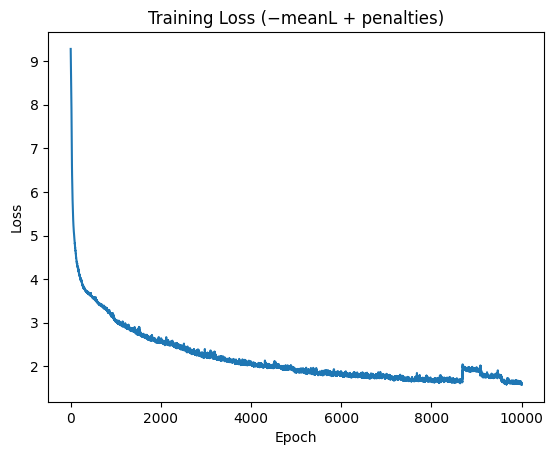

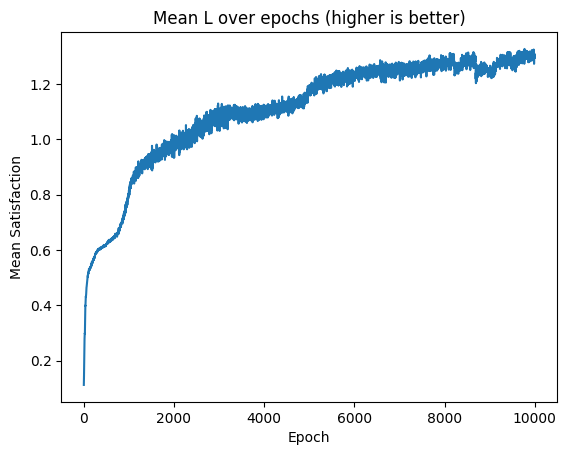

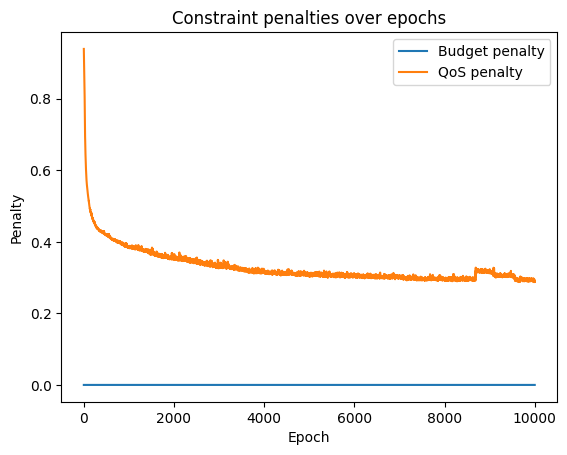

In [200]:
import matplotlib.pyplot as plt

if 'logs' in globals() and isinstance(logs, list) and len(logs) > 0:
    import pandas as pd
    df_logs = pd.DataFrame(logs)

    plt.figure()
    plt.plot(df_logs["epoch"], df_logs["loss"])
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Training Loss (−meanL + penalties)")
    plt.show()

    if "meanL" in df_logs:
        plt.figure()
        plt.plot(df_logs["epoch"], df_logs["meanL"])
        plt.xlabel("Epoch"); plt.ylabel("Mean Satisfaction")
        plt.title("Mean L over epochs (higher is better)")
        plt.show()

    if "budget" in df_logs and "qos" in df_logs:
        plt.figure()
        plt.plot(df_logs["epoch"], df_logs["budget"], label="Budget penalty")
        plt.plot(df_logs["epoch"], df_logs["qos"], label="QoS penalty")
        plt.xlabel("Epoch"); plt.ylabel("Penalty")
        plt.title("Constraint penalties over epochs")
        plt.legend()
        plt.show()


In [201]:
stats, per_user = evaluate_policy_snapshot(policy, data, aux)
print("Snapshot stats:", stats)

Snapshot stats: {'mean_L': 1.299781322479248, 'mean_rate': 1.2655351161956787, 'mean_wLTE': 0.18997494876384735, 'mean_P': 0.04174857214093208, 'budget_violation_mean': 0.0, 'qos_violation_mean': 0.290290892124176}


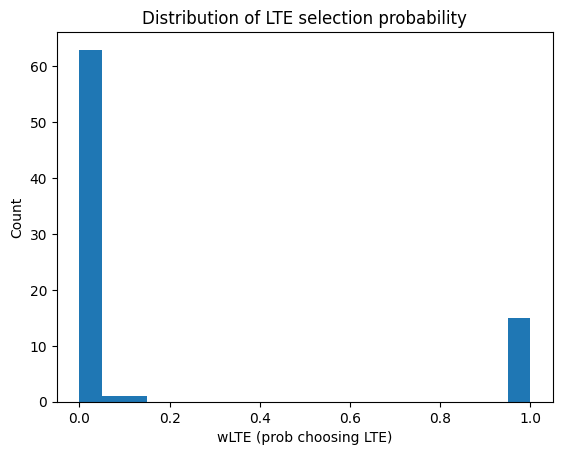

In [202]:
plt.figure()
plt.hist(per_user["wL"], bins=20)
plt.xlabel("wLTE (prob choosing LTE)")
plt.ylabel("Count")
plt.title("Distribution of LTE selection probability")
plt.show()


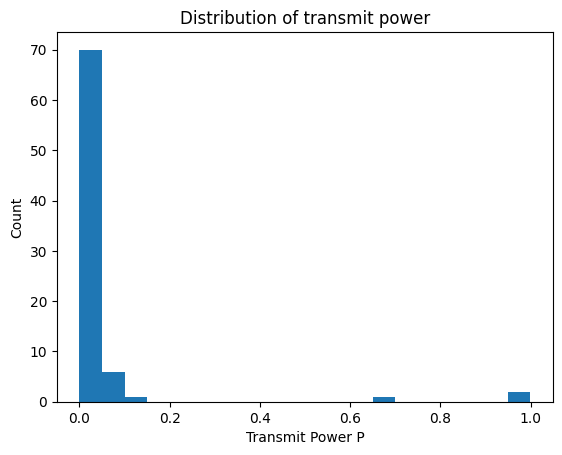

In [203]:
plt.figure()
plt.hist(per_user["P"], bins=20)
plt.xlabel("Transmit Power P")
plt.ylabel("Count")
plt.title("Distribution of transmit power")
plt.show()


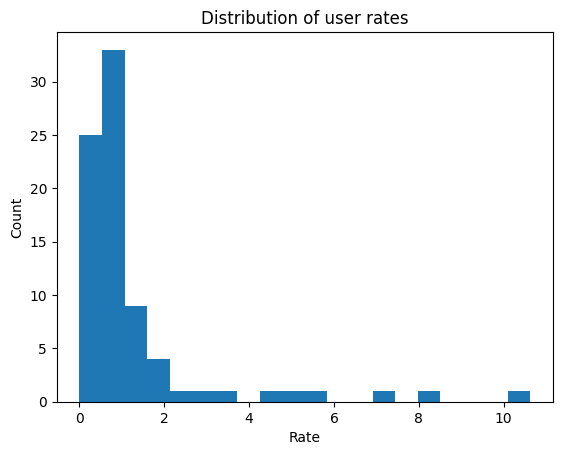

In [206]:
plt.figure()
plt.hist(per_user["rate"], bins=20)
plt.xlabel("Rate")
plt.ylabel("Count")
plt.title("Distribution of user rates")
plt.show()


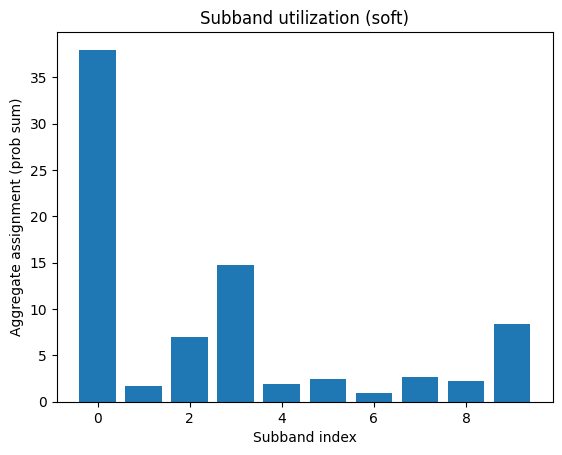

In [207]:
subband_load = per_user["subband_load"]  # shape (F,)
plt.figure()
plt.bar(range(len(subband_load)), subband_load)
plt.xlabel("Subband index")
plt.ylabel("Aggregate assignment (prob sum)")
plt.title("Subband utilization (soft)")
plt.show()


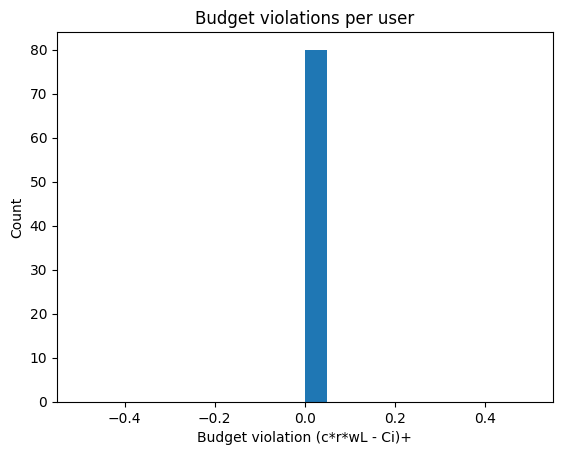

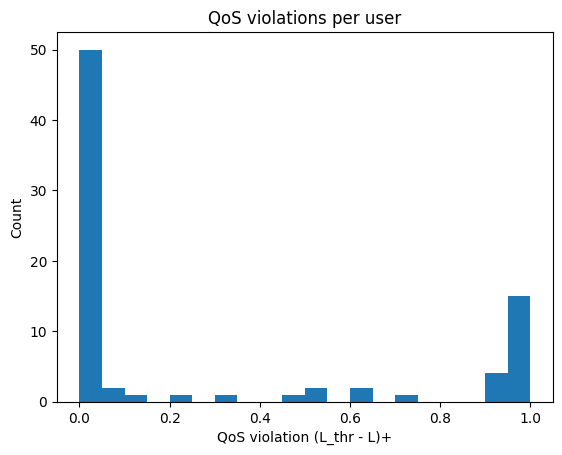

In [208]:
plt.figure()
plt.hist(per_user["budget_violation"], bins=20)
plt.xlabel("Budget violation (c*r*wL - Ci)+")
plt.ylabel("Count")
plt.title("Budget violations per user")
plt.show()

plt.figure()
plt.hist(per_user["qos_violation"], bins=20)
plt.xlabel("QoS violation (L_thr - L)+")
plt.ylabel("Count")
plt.title("QoS violations per user")
plt.show()
